# Base DL models

## 0. Import library

In [1]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
pd.options.display.float_format = "{:,.4f}".format
import gc

import warnings;
warnings.filterwarnings('ignore')

In [2]:
# model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score


In [3]:
# deep learning algo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import backend
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Fixing the seed for random number generators
tf.random.set_seed(42)

# keras tuner
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# keras tuner
# !pip install keras-tuner --upgrade
from kerastuner.tuners import RandomSearch

## 1. Import data

In [5]:
df = pd.read_csv('reviews_cleaned.csv', parse_dates=['timestamp_created'])

In [6]:
df.head()

,recommendationid,review,timestamp_created,voted_up
0,132354840,loe love love game purchased sale would recomm...,2023-02-07,True
1,132354176,fun,2023-02-07,True
2,132353890,full gen z game,2023-02-07,False
3,132353500,good,2023-02-07,True
4,132352818,captivating like movie,2023-02-07,True


In [7]:
 df['voted_up'].value_counts(), df['voted_up'].value_counts(normalize = True)

(True     304152
 False    158426
 Name: voted_up, dtype: int64,
 True    0.6575
 False   0.3425
 Name: voted_up, dtype: float64)

## 2. Preprocess

### Exclude 5% of the most recent reviews for holdout set

<Axes: xlabel='timestamp_created', ylabel='Count'>

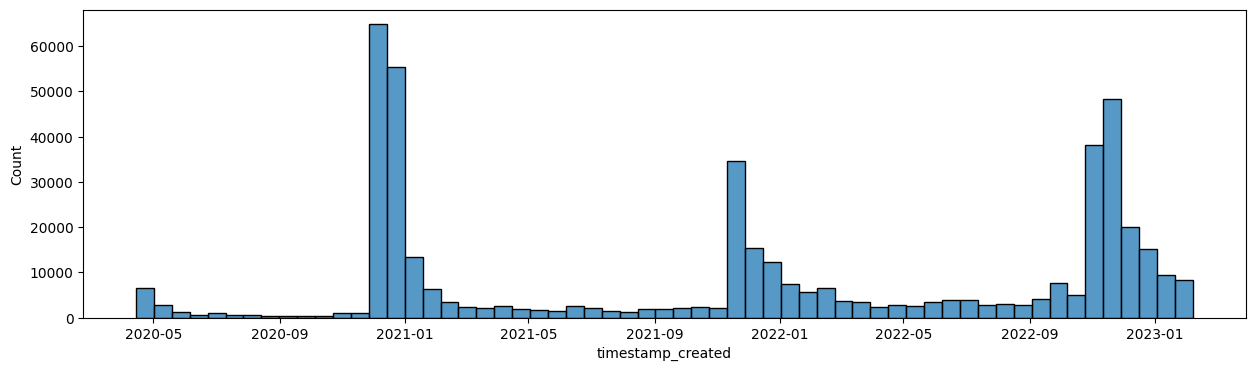

In [8]:
plt.figure(figsize=(15,4))
sns.histplot(x=df.timestamp_created)

In [9]:
# date of 95th quantile reviews
df.timestamp_created.quantile(0.95)

Timestamp('2022-12-28 00:00:00')

In [10]:
%%time
X = df['review']

X_holdout = X[df.timestamp_created >= df.timestamp_created.quantile(0.95)]
X = X[df.timestamp_created < df.timestamp_created.quantile(0.95)]

X

CPU times: total: 15.6 ms
Wall time: 107 ms


6282           great game might update gpu make work better
6283      theyve fixed game pretty well couple bug encou...
6284                           cuz really wanna stay housee
6285                               finally game story great
6286                                               bee knee
                                ...                        
462573      game wajib untuk budak ea sungkem yang mulia ea
462574    lot change fifa afterall finally good feeling ...
462575    first time played ultimate team got honest tot...
462576    loved game much waiting fifa 22 since august w...
462577                                fifa nothing else say
Name: review, Length: 439032, dtype: object

In [11]:
y = df['voted_up'][df.timestamp_created < df.timestamp_created.quantile(0.95)]
y_holdout = df['voted_up'][df.timestamp_created >= df.timestamp_created.quantile(0.95)]

### Bag of words

In [12]:
def bow_vectorizer(X_train, X_test, n_features):
    vectorizer = CountVectorizer(max_features = n_features, dtype = np.uint8)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    # X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    # X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())
    return X_train.toarray(), X_test.toarray()

### TF IDF

In [13]:
def tfidf_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    # X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    # X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train.toarray(), X_test.toarray()

### TF IDF with bigram

In [14]:
def tfidf2g_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features, ngram_range=(1,2))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    # X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    # X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train.toarray(), X_test.toarray()

## 3. Tuning

### Function for metrics

In [15]:
columns = ['model name', 'data', 'time', 
           'train_down_Pre',
           'train_down_Rec',
           'train_down_F1',
           'train_up_Pre',
           'train_up_Rec',
           'train_up_F1',
           'train_acc',
           'test_down_Pre',
           'test_down_Rec',
           'test_down_F1',
           'test_up_Pre',
           'test_up_Rec',
           'test_up_F1',
           'test_acc']
           
df_metrics = pd.DataFrame(columns = columns)

In [16]:
def reset(df_metrics):
    return pd.DataFrame(columns = columns)

In [17]:
def dl_performance(model_name, model, X_name, X_train, X_test, y_train, y_test, complete_time = 0, threshold = 0.5): #, X_train, X_test, y_train, y_test):
    
    #print('Training: ', model_name, '/', X_name)
    y_hat_train = np.where(model.predict(X_train) > threshold,1,0)
    y_hat_test = np.where(model.predict(X_test) > threshold,1,0)
    
    
    # Train ##############
    # accuracy
    accuracy_train = accuracy_score(y_train, y_hat_train)
    # pre/rec/f1 for True
    precision_train_True = precision_score(y_train, y_hat_train, pos_label = True)
    recall_train_True = recall_score(y_train, y_hat_train, pos_label = True)
    F1_train_True = f1_score(y_train, y_hat_train, pos_label = True)
    
    # pre/rec/f1 for false
    precision_train_False = precision_score(y_train, y_hat_train, pos_label = False)
    recall_train_False = recall_score(y_train, y_hat_train, pos_label = False)
    F1_train_False = f1_score(y_train, y_hat_train, pos_label = False)
    
    # Test ##############
    # accuracy
    accuracy_test = accuracy_score(y_test, y_hat_test)
    # pre/rec/f1 for True
    precision_test_True = precision_score(y_test, y_hat_test, pos_label = True)
    recall_test_True = recall_score(y_test, y_hat_test, pos_label = True)
    F1_test_True = f1_score(y_test, y_hat_test, pos_label = True)

    # pre/rec/f1 for false
    precision_test_False = precision_score(y_test, y_hat_test, pos_label = False)
    recall_test_False = recall_score(y_test, y_hat_test, pos_label = False)
    F1_test_False = f1_score(y_test, y_hat_test, pos_label = False)

    # store result
    df_metrics.loc[len(df_metrics.index)] = [
        model_name, X_name, complete_time, 
        precision_train_False, recall_train_False, F1_train_False,
        precision_train_True,  recall_train_True,  F1_train_True, accuracy_train,
        precision_test_False,  recall_test_False,  F1_test_False, 
        precision_test_True,   recall_test_True,   F1_test_True, accuracy_test]
    
    print('Train')
    print(classification_report(y_train, y_hat_train))
    print('Test')
    print(classification_report(y_test, y_hat_test))

    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(6,3))
    labels = ['Negative', 'Positive']

    sns.heatmap(confusion_matrix(y_train, y_hat_train), annot=True, ax=ax1, 
                cbar=False, xticklabels=labels, yticklabels=labels, fmt='.0f')
    sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax2, 
                cbar=False, xticklabels=labels, yticklabels=labels, fmt='.0f')
    ax1.set(ylabel='Actual', xlabel='Predicted') 
    ax2.set(ylabel='Actual', xlabel='Predicted')
    plt.tight_layout()
    plt.show()
    print('Finished in',complete_time)
    print('='*50)
    # return df_metrics.loc[len(df_metrics.index)-1]

In [18]:
def accuracy_vs_epochs(history, from_epoc=0):
    df_history = pd.DataFrame(history.history).iloc[from_epoc:]
    plt.figure(figsize = (4,2))
    plt.plot(df_history.iloc[:,1])
    plt.plot(df_history.iloc[:,3])
    plt.xlim(left=-1)
    plt.title(str(df_history.columns[1]) +  ' vs epochs')
    plt.ylabel(df_history.columns[1])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

In [19]:
def DL_model_fit(model_name, model, callback, X_name, X_train_vectorized, X_test_vectorized, y_train, y_test):    
    print(f'Training:  {model_name} / {X_name}')
    start = time.time()
    backend.clear_session()

    history = model.fit(X_train_vectorized, y_train, 
                        batch_size=32,
                        epochs=10,
                        callbacks=[callback],
                        verbose=1,
                        validation_split = 0.1)
    completion_time = round(time.time() - start,2)
    accuracy_vs_epochs(history)
    dl_performance(model_name, model, X_name, X_train_vectorized, X_test_vectorized, y_train, y_test, completion_time)

In [20]:
# function to create DL model
def make_DL_model(neuron_list, dropout_list, input_dim, metric=tf.keras.metrics.AUC()):
    
    model = Sequential()
    model.add(Dense(neuron_list[0], activation='relu',kernel_initializer='he_uniform',input_dim = input_dim))
    model.add(Dropout(dropout_list[0]))
    
    for neuron, dropout in zip(neuron_list[1:], dropout_list[1:]):
        model.add(Dense(neuron,activation='relu',kernel_initializer='he_uniform'))
        model.add(Dropout(dropout))
   
    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.001), metrics=metric)
    return model

In [25]:
# function to create DL model
def make_DL_model_tune(neuron_list, dropout_list, activator_list, input_dim, metric=tf.keras.metrics.AUC()):
    
    model = Sequential()
    model.add(Dense(neuron_list[0], activation=activator_list[0],kernel_initializer='he_uniform',input_dim = input_dim))
    model.add(Dropout(dropout_list[0]))
    
    for neuron, dropout, activator in zip(neuron_list[1:], dropout_list[1:], activator_list[1:]):
        model.add(Dense(neuron,activation=activator,kernel_initializer='he_uniform'))
        model.add(Dropout(dropout))
   
    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.001), metrics=metric)
    return model

In [30]:
# function to plot precision/recall curve
def pre_rec_curve(model, X_train_vectorized, threshold=0.5):
    y_proba= model.predict(X_train_vectorized)
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba, pos_label=1)
    thresholds = np.insert(thresholds, 0, 0)
    F1_score = 2*precisions*recalls/(precisions+recalls)

    # Plot values of precisions, recalls, and thresholds
    plt.figure(figsize=(10,7))
    plt.plot(thresholds, precisions, 'b--', label='precision')
    plt.plot(thresholds, recalls, 'g--', label = 'recall')
    plt.plot(thresholds, F1_score, 'r--', label = 'f1 score')

    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    # plt.ylim([0.6,1])
    plt.axvline(threshold)
    plt.show()

### Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=14)

# X_train_bow_2000    , X_test_bow_2000     = bow_vectorizer(X_train, X_test, 2000)
# X_train_tfidf_2000  , X_test_tfidf_2000   = tfidf_vectorizer(X_train, X_test, 2000)
X_train_tfidf2g_2000, X_test_tfidf2g_2000 = tfidf2g_vectorizer(X_train, X_test, 2000)

In [22]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

### Baseline model

In [29]:
DL_based = tf.keras.models.load_model('DL_4layer_model_tfidf2g')

2744/2744 [==============================] - 6s 2ms/step
Train
              precision    recall  f1-score   support

       False       0.85      0.84      0.85    120213
        True       0.92      0.92      0.92    231012

    accuracy                           0.89    351225
   macro avg       0.88      0.88      0.88    351225
weighted avg       0.89      0.89      0.89    351225

Test
              precision    recall  f1-score   support

       False       0.81      0.80      0.81     30053
        True       0.90      0.90      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.85      0.85      0.85     87807
weighted avg       0.87      0.87      0.87     87807



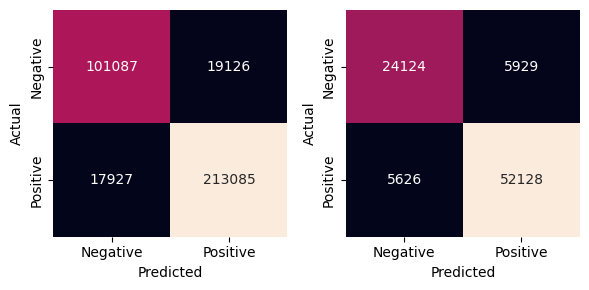

Finished in 0


model name            DL_based
data              tfidf2g_2000
time                         0
train_down_Pre          0.8494
train_down_Rec          0.8409
train_down_F1           0.8451
train_up_Pre            0.9176
train_up_Rec            0.9224
train_up_F1             0.9200
train_acc               0.8945
test_down_Pre           0.8109
test_down_Rec           0.8027
test_down_F1            0.8068
test_up_Pre             0.8979
test_up_Rec             0.9026
test_up_F1              0.9002
test_acc                0.8684
Name: 0, dtype: object

In [32]:
dl_performance('DL_based', DL_based, 'tfidf2g_2000', X_train_tfidf2g_2000, X_test_tfidf2g_2000, y_train, y_test, threshold = 0.6)

### Random search

In [46]:
def build_model(h):
    model = keras.Sequential()
    # Number of layer: min - max
    for i in range(h.Int('num_layers', 2, 10)):
        # Number of neuron in each layer: min - max - step
        model.add(layers.Dense(
            #units=h.Int('units_' + str(i), min_value=32, max_value=512, step=32),
            units=h.Choice('units_' + str(i), [512, 256, 128, 64, 32]),
            # Activation function for each layer
            activation= h.Choice('act_' + str(i), ['relu','sigmoid'])))
        # Tune with dropout or not
        model.add(Dropout(h.Choice('dropout_'+ str(i), [0.0, 0.1,0.25,0.5])))
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    # compiler
    model.compile(
        # Adjust learning rate
        optimizer=keras.optimizers.Adam(h.Choice('learning_rate', [0.001, 0.01])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [47]:
X_train_cv, _ , y_train_cv, __ = train_test_split(X_train_tfidf2g_2000, y_train, train_size=0.1, stratify = y_train,
                                                  random_state=14)

In [48]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=7,
    project_name='Job',
    overwrite=True)

In [49]:
# Tuning completed in:  2312.38 s
start = time.time()
tuner.search(X_train_cv, y_train_cv, epochs=7, validation_split = 0.1)
print('Tuning completed in: ', round(time.time()-start,2),'s')

Trial 10 Complete [00h 03m 25s]
val_accuracy: 0.8284331730433873

Best val_accuracy So Far: 0.8573868444987706
Total elapsed time: 00h 38m 32s
INFO:tensorflow:Oracle triggered exit
Tuning completed in:  2312.38 s


In [50]:
tuner.results_summary()


Results summary
Results in .\Job
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 128
act_0: relu
dropout_0: 0.25
units_1: 256
act_1: sigmoid
dropout_1: 0.5
learning_rate: 0.001
units_2: 32
act_2: sigmoid
dropout_2: 0.25
units_3: 64
act_3: sigmoid
dropout_3: 0.1
units_4: 128
act_4: sigmoid
dropout_4: 0.0
units_5: 32
act_5: sigmoid
dropout_5: 0.5
units_6: 64
act_6: sigmoid
dropout_6: 0.5
Score: 0.8573868444987706
Trial summary
Hyperparameters:
num_layers: 5
units_0: 128
act_0: relu
dropout_0: 0.25
units_1: 256
act_1: sigmoid
dropout_1: 0.25
learning_rate: 0.001
units_2: 512
act_2: sigmoid
dropout_2: 0.0
units_3: 32
act_3: sigmoid
dropout_3: 0.5
units_4: 32
act_4: relu
dropout_4: 0.1
units_5: 256
act_5: sigmoid
dropout_5: 0.25
units_6: 32
act_6: relu
dropout_6: 0.1
Score: 0.8568175435066223
Trial summary
Hyperparameters:
num_layers: 7
units_0: 32
act_0: relu
dropout_0: 0.25
units_1: 128
act_1: relu
dropout_1: 0.25
learning_rate: 0.001
units_2: 512
act_2: relu


In [ ]:
# Hyperparameters:
# num_layers: 5
# units_0: 128
# act_0: relu
# dropout_0: 0.25
# units_1: 256
# act_1: sigmoid
# dropout_1: 0.5
# learning_rate: 0.001
# units_2: 32
# act_2: sigmoid
# dropout_2: 0.25
# units_3: 64
# act_3: sigmoid
# dropout_3: 0.1
# units_4: 128
# act_4: sigmoid
# dropout_4: 0.0
# units_5: 32
# act_5: sigmoid
# dropout_5: 0.5
# units_6: 64
# act_6: sigmoid
# dropout_6: 0.5
# Score: 0.8573868444987706

# Hyperparameters:
# num_layers: 5
# units_0: 128
# act_0: relu
# dropout_0: 0.25
# units_1: 256
# act_1: sigmoid
# dropout_1: 0.25
# learning_rate: 0.001
# units_2: 512
# act_2: sigmoid
# dropout_2: 0.0
# units_3: 32
# act_3: sigmoid
# dropout_3: 0.5
# units_4: 32
# act_4: relu
# dropout_4: 0.1
# units_5: 256
# act_5: sigmoid
# dropout_5: 0.25
# units_6: 32
# act_6: relu
# dropout_6: 0.1
# Score: 0.8568175435066223

# Hyperparameters:
# num_layers: 7
# units_0: 32
# act_0: relu
# dropout_0: 0.25
# units_1: 128
# act_1: relu
# dropout_1: 0.25
# learning_rate: 0.001
# units_2: 512
# act_2: relu
# dropout_2: 0.1
# units_3: 32
# act_3: relu
# dropout_3: 0.0
# units_4: 32
# act_4: sigmoid
# dropout_4: 0.0
# units_5: 512
# act_5: sigmoid
# dropout_5: 0.0
# units_6: 512
# act_6: relu
# dropout_6: 0.0
# Score: 0.8558009096554348

# Hyperparameters:
# num_layers: 5
# units_0: 256
# act_0: relu
# dropout_0: 0.5
# units_1: 32
# act_1: sigmoid
# dropout_1: 0.0
# learning_rate: 0.01
# units_2: 32
# act_2: relu
# dropout_2: 0.5
# units_3: 64
# act_3: sigmoid
# dropout_3: 0.5
# units_4: 512
# act_4: sigmoid
# dropout_4: 0.0
# units_5: 256
# act_5: sigmoid
# dropout_5: 0.1
# units_6: 64
# act_6: sigmoid
# dropout_6: 0.0
# Score: 0.8535643134798322

### Random search model 1

In [27]:
DL_tune1 = make_DL_model_tune(
    [128,256,32,64,128], 
    [.25, .5, .25, .1, 0], 
    ['relu', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid'],
    2000, metric='accuracy')

Training:  DL_tune1 / tfidf2g_2000
Epoch 1/10
9879/9879 [==============================] - 31s 3ms/step - loss: 0.3474 - accuracy: 0.8522 - val_loss: 0.3259 - val_accuracy: 0.8618
Epoch 2/10
9879/9879 [==============================] - 33s 3ms/step - loss: 0.3208 - accuracy: 0.8648 - val_loss: 0.3160 - val_accuracy: 0.8666
Epoch 3/10
9879/9879 [==============================] - 28s 3ms/step - loss: 0.3072 - accuracy: 0.8723 - val_loss: 0.3125 - val_accuracy: 0.8702
Epoch 4/10
9879/9879 [==============================] - 29s 3ms/step - loss: 0.2937 - accuracy: 0.8795 - val_loss: 0.3117 - val_accuracy: 0.8708
Epoch 5/10
9879/9879 [==============================] - 29s 3ms/step - loss: 0.2800 - accuracy: 0.8865 - val_loss: 0.3119 - val_accuracy: 0.8707
Epoch 6/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.2646 - accuracy: 0.8942 - val_loss: 0.3232 - val_accuracy: 0.8707
Epoch 7/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.2509 - accuracy:

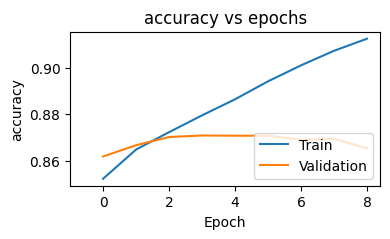

2744/2744 [==============================] - 3s 1ms/step
Train
              precision    recall  f1-score   support

       False       0.87      0.80      0.83    120213
        True       0.90      0.94      0.92    231012

    accuracy                           0.89    351225
   macro avg       0.88      0.87      0.88    351225
weighted avg       0.89      0.89      0.89    351225

Test
              precision    recall  f1-score   support

       False       0.84      0.76      0.80     30053
        True       0.88      0.93      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.86      0.84      0.85     87807
weighted avg       0.87      0.87      0.87     87807



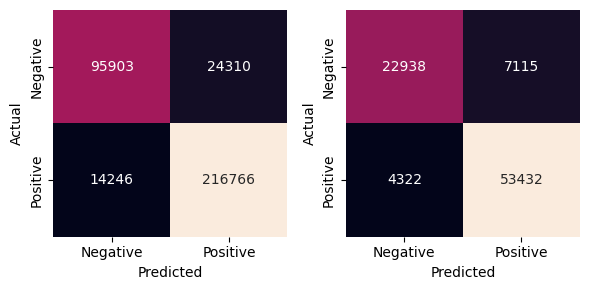

Finished in 273.42


In [28]:
DL_model_fit('DL_tune1', DL_tune1, callback, 'tfidf2g_2000', X_train_tfidf2g_2000, X_test_tfidf2g_2000, y_train, y_test)

10976/10976 [==============================] - 14s 1ms/step


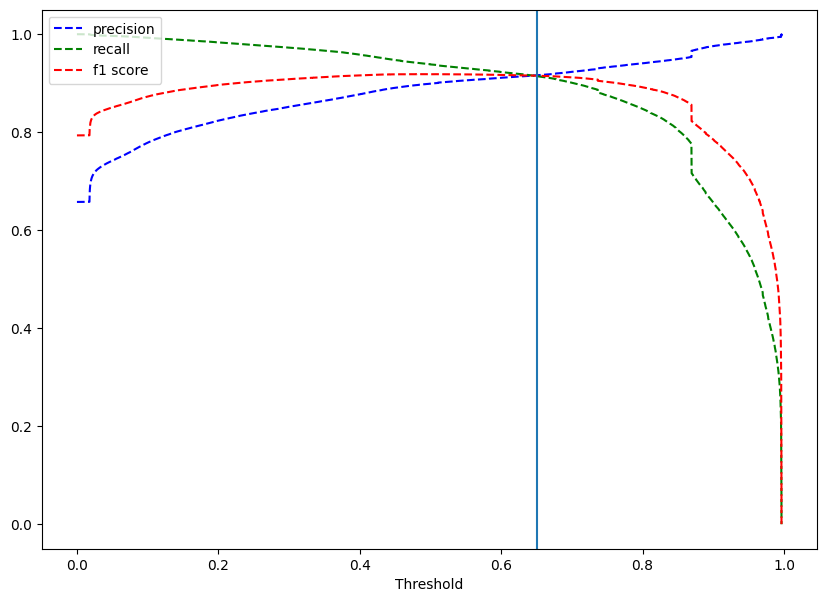

In [32]:
pre_rec_curve(DL_tune1, X_train_tfidf2g_2000, threshold=0.65)

2744/2744 [==============================] - 4s 1ms/step
Train
              precision    recall  f1-score   support

       False       0.84      0.84      0.84    120213
        True       0.92      0.91      0.92    231012

    accuracy                           0.89    351225
   macro avg       0.88      0.88      0.88    351225
weighted avg       0.89      0.89      0.89    351225

Test
              precision    recall  f1-score   support

       False       0.81      0.81      0.81     30053
        True       0.90      0.90      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.85      0.85      0.85     87807
weighted avg       0.87      0.87      0.87     87807



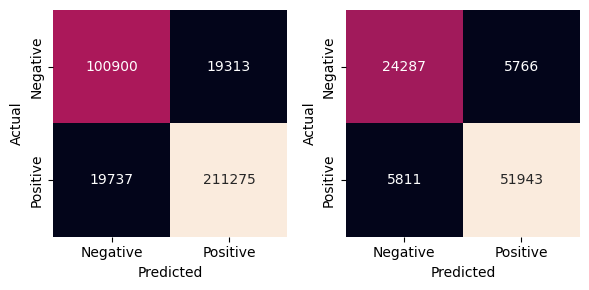

Finished in 0


In [33]:
dl_performance('DL_tune1', DL_tune1, 'tfidf2g_2000_0.65', X_train_tfidf2g_2000, X_test_tfidf2g_2000, y_train, y_test, threshold = 0.65)

### Random search model 2

In [ ]:
# Hyperparameters:
# num_layers: 5
# units_0: 128
# act_0: relu
# dropout_0: 0.25
# units_1: 256
# act_1: sigmoid
# dropout_1: 0.25
# learning_rate: 0.001
# units_2: 512
# act_2: sigmoid
# dropout_2: 0.0
# units_3: 32
# act_3: sigmoid
# dropout_3: 0.5
# units_4: 32
# act_4: relu
# dropout_4: 0.1

# Score: 0.8568175435066223

In [34]:
DL_tune2 = make_DL_model_tune(
    [128,256, 512, 32 ,32], 
    [.25, .5, .0, .5, .1], 
    ['relu', 'sigmoid', 'sigmoid', 'sigmoid', 'relu'],
    2000, metric='accuracy')

Training:  DL_tune2 / tfidf2g_2000
Epoch 1/10
9879/9879 [==============================] - 31s 3ms/step - loss: 0.3563 - accuracy: 0.8495 - val_loss: 0.3263 - val_accuracy: 0.8615
Epoch 2/10
9879/9879 [==============================] - 29s 3ms/step - loss: 0.3219 - accuracy: 0.8648 - val_loss: 0.3276 - val_accuracy: 0.8662
Epoch 3/10
9879/9879 [==============================] - 31s 3ms/step - loss: 0.3097 - accuracy: 0.8716 - val_loss: 0.3200 - val_accuracy: 0.8679
Epoch 4/10
9879/9879 [==============================] - 31s 3ms/step - loss: 0.2974 - accuracy: 0.8783 - val_loss: 0.3150 - val_accuracy: 0.8706
Epoch 5/10
9879/9879 [==============================] - 34s 3ms/step - loss: 0.2844 - accuracy: 0.8847 - val_loss: 0.3125 - val_accuracy: 0.8706
Epoch 6/10
9879/9879 [==============================] - 29s 3ms/step - loss: 0.2704 - accuracy: 0.8919 - val_loss: 0.3143 - val_accuracy: 0.8698
Epoch 7/10
9879/9879 [==============================] - 31s 3ms/step - loss: 0.2575 - accuracy:

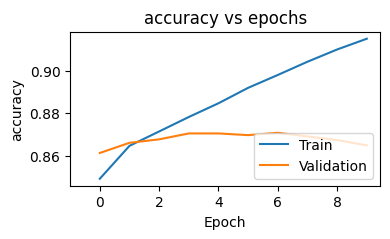

2744/2744 [==============================] - 3s 1ms/step
Train
              precision    recall  f1-score   support

       False       0.86      0.84      0.85    120213
        True       0.92      0.93      0.92    231012

    accuracy                           0.90    351225
   macro avg       0.89      0.88      0.88    351225
weighted avg       0.90      0.90      0.90    351225

Test
              precision    recall  f1-score   support

       False       0.82      0.80      0.81     30053
        True       0.89      0.91      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.86      0.85      0.85     87807
weighted avg       0.87      0.87      0.87     87807



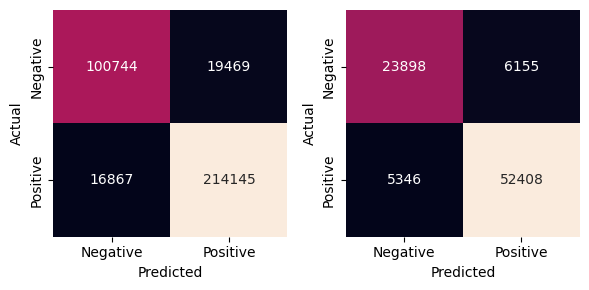

Finished in 309.52


In [35]:
DL_model_fit('DL_tune2', DL_tune2, callback, 'tfidf2g_2000', X_train_tfidf2g_2000, X_test_tfidf2g_2000, y_train, y_test)

10976/10976 [==============================] - 13s 1ms/step


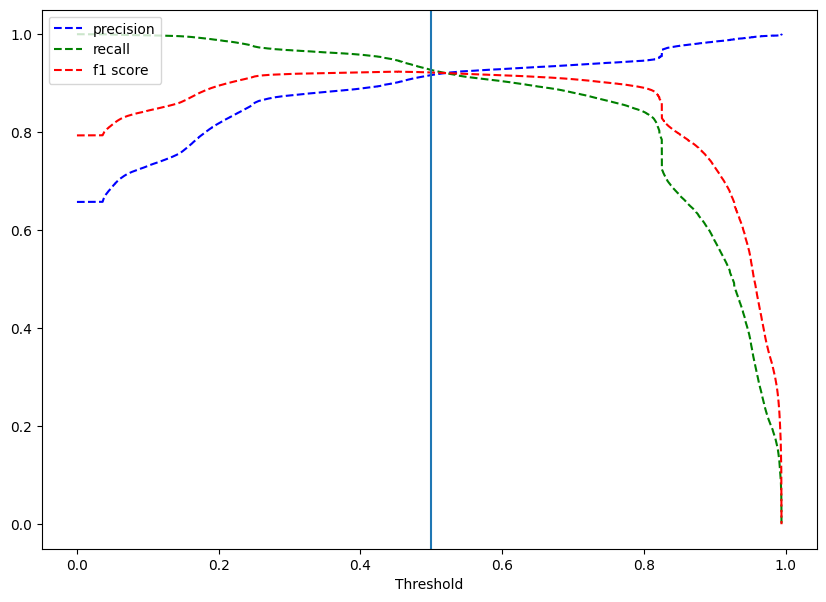

In [38]:
pre_rec_curve(DL_tune2, X_train_tfidf2g_2000, threshold=0.5)

### Dash

https://ml.dask.org/keras.html

In [29]:
import dask_ml.model_selection as dcv
# from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.1, random_state=14)

X_train_tfidf2g_2000, X_test_tfidf2g_2000 = tfidf2g_vectorizer(X_train, X_test, 2000)
del X_test_tfidf2g_2000

In [31]:
param_grid = {'num_layers': range(2, 6),
              'num_neurons': range(32, 64, 128),
              'activation': ['relu', 'sigmoid']}

def create_model(num_layers, num_neurons, activation):
    model = Sequential()
    for i in range(num_layers):
        model.add(Dense(units=num_neurons, activation=activation))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_dask = KerasClassifier(build_fn=create_model, num_layers=None, num_neurons=None, activation=None)

dask_grid = dcv.GridSearchCV(estimator=model_dask, param_grid=param_grid, cv=3)

dask_grid.fit(X_train_tfidf2g_2000, y_train, verbose=1)

1382/1382 [==============================] - 8s 4ms/step - loss: 0.3804 - accuracy: 0.8320


GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5e8f8e82e0>,
             param_grid={'activation': ['relu', 'sigmoid'],
                         'num_layers': range(2, 6),
                         'num_neurons': range(32, 64, 128)})

In [32]:
dask_grid.cv_results_

{'params': [{'activation': 'relu', 'num_layers': 2, 'num_neurons': 32},
  {'activation': 'relu', 'num_layers': 3, 'num_neurons': 32},
  {'activation': 'relu', 'num_layers': 4, 'num_neurons': 32},
  {'activation': 'relu', 'num_layers': 5, 'num_neurons': 32},
  {'activation': 'sigmoid', 'num_layers': 2, 'num_neurons': 32},
  {'activation': 'sigmoid', 'num_layers': 3, 'num_neurons': 32},
  {'activation': 'sigmoid', 'num_layers': 4, 'num_neurons': 32},
  {'activation': 'sigmoid', 'num_layers': 5, 'num_neurons': 32}],
 'mean_fit_time': array([14.7600391 , 10.8544232 , 11.59445694, 13.02906332, 10.88644017,
        11.93128282, 12.30221477, 12.44144957]),
 'std_fit_time': array([7.08799639, 1.17576919, 0.68683345, 0.49478711, 1.24288462,
        0.99146745, 2.16510171, 0.4089445 ]),
 'mean_score_time': array([2.50916805, 3.13434682, 3.17610057, 2.59971756, 2.31473641,
        2.84156424, 3.98294736, 3.09731037]),
 'std_score_time': array([0.75995079, 0.82099079, 0.0604207 , 0.46500324, 0.677